# Final Implementation of Explicit Collaborative Filtering Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

Import train/test split data from `Temporal_Train_Test_Split.ipynb`

In [ ]:
train_la = pd.read_pickle("ip_listing_temporal_train_full.pkl")
test_la = pd.read_pickle("ip_listing_temporal_test_full.pkl")

Visualize an example split for a random user

In [ ]:
print('train')
display(train_la[train_la.ip=='100.11.168.44'])
print('test')
display(test_la[test_la.ip=='100.11.168.44'])

train


,ip,rexUrl
98,100.11.168.44,22718-figueroa-st-unit-21
98,100.11.168.44,6151-orange-st-apt-118
98,100.11.168.44,6210-s-van-ness-ave
98,100.11.168.44,9735-baden-ave
98,100.11.168.44,13514-chivers-ave
98,100.11.168.44,1410-brett-pl-unit-238
98,100.11.168.44,830-n-oakway-ave
98,100.11.168.44,6209-pacific-ave-unit-101
98,100.11.168.44,814-e-graves-ave


test


,ip,rexUrl
98,100.11.168.44,28710-indies-ln-canyon-country
98,100.11.168.44,15015-lassen-st
98,100.11.168.44,844-e-meadbrook-st


In [ ]:
train_la.head()

,ip,rexUrl
11,1.129.109.119,15819-golden-lantern-ln
11,1.129.109.119,3332-genoa-pl
11,1.129.109.119,12401-moorpark-st-unit-201-studio-city
65,1.65.170.128,1270-bayport-cir
65,1.65.170.128,656-w-avenue-j8


## Scoring Interactions

Bring in webdata from `Load_Web_Data.ipynb`

In [ ]:
webdata = pd.read_pickle("all_webdata_filtered.pkl")

In [ ]:
train_webdata = train_la.merge(webdata,left_on=['ip','rexUrl'],right_on=['ip','rexurl'],how='left')

In [ ]:
train_webdata.head()

,ip,rexUrl,event_stamp,action,category,rexurl,rexUrl_duration
0,1.129.109.119,15819-golden-lantern-ln,2019-09-07 02:11:35.493,pageview,NaN,15819-golden-lantern-ln,60.059
1,1.129.109.119,15819-golden-lantern-ln,2019-09-07 02:11:44.866,scroll,photoCarousel,15819-golden-lantern-ln,60.059
2,1.129.109.119,15819-golden-lantern-ln,2019-09-07 02:11:45.075,scroll,photoCarousel,15819-golden-lantern-ln,60.059
3,1.129.109.119,15819-golden-lantern-ln,2019-09-07 02:11:54.897,scroll,photoCarousel,15819-golden-lantern-ln,60.059
4,1.129.109.119,15819-golden-lantern-ln,2019-09-07 02:11:55.070,scroll,photoCarousel,15819-golden-lantern-ln,60.059


In [ ]:
special_actions_level0 = ['scroll','pageview','ViewContent','view_item','drag','click']
special_actions_level1 = ['open-form','enter-flow',  'nav-tab', 'change',
                          'success', 'Search', 'view_search_results', 'phone-click', 'popup']
special_actions_level2 = ['nav', 'lead', 'submit', 'submit-success','add_to_cart', 'InitiateCheckout']
special_actions_level3 = ['Purchase','purchase']

In [ ]:
# Determining how common each action is
# To be used for inverse frequency weighting in score calculation (below)
action_ct = train_webdata.action.value_counts()
total_ct = action_ct.sum()
level_weights = []
for i, curr_level in enumerate([special_actions_level0, special_actions_level1, 
                           special_actions_level2, special_actions_level3]):
  
  # futureproofing index lookup for cases when not all actions are there
  Lx_weight = 100*action_ct[action_ct.index.isin(curr_level)].sum()/total_ct
  level_weights.append(Lx_weight)
  print("Level {0:d}: {1:.4f} %".format(i+1, Lx_weight))

Level 1: 99.3950 %
Level 2: 0.5086 %
Level 3: 0.0620 %
Level 4: 0.0076 %


In [ ]:
# aggregating interaction data into levels
group_df_pre = train_webdata.groupby(by=['ip', 'rexUrl']).agg(scroll_ct = ('action',lambda x: sum(x=="scroll")),
                                                   pageview_ct = ('action',lambda x: sum(x=="pageview")),
                                                   viewcontent_ct = ('action',lambda x: sum(x=='ViewContent')),
                                                   view_item_ct = ('action',lambda x: sum(x=='view_item')),
                                                   drag_ct = ('action',lambda x: sum(x=='drag')),
                                                   click_ct = ('action',lambda x: sum(x=='click')),
                                                   level0_ct = ('action', lambda x: sum(np.isin(x, special_actions_level0))),
                                                   level1_ct = ('action', lambda x: sum(np.isin(x, special_actions_level1))),
                                                   level2_ct = ('action', lambda x: sum(np.isin(x, special_actions_level2))),
                                                   level3_ct = ('action', lambda x: sum(np.isin(x, special_actions_level3))))

In [ ]:
# Define intent score calculation
def calculate_score(row):
  curr_score = 0
  for i in range(4):
    curr_weight = 1/level_weights[i]
    curr_score += row[f'level{i}_ct']*curr_weight
  return np.clip(curr_score,0,6)
  # return np.ceil(np.clip(curr_score,0,6))

group_df_pre['score'] = group_df_pre.apply(lambda x: calculate_score(x), axis=1)

## input for CF model
df_grp = group_df_pre.reset_index()[['ip', 'rexUrl','score']]

In [ ]:
print(df_grp.shape)
print(train_la.shape)

(51060, 3)
(51060, 2)


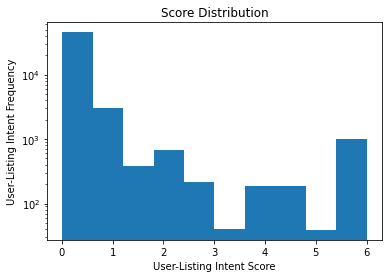

In [ ]:
plt.hist(df_grp.score)
plt.title('Score Distribution')
plt.yscale('log')
plt.xlabel('User-Listing Intent Score')
plt.ylabel('User-Listing Intent Frequency')
plt.show()

### CF Modeling using `surprise` package

In [ ]:
! pip install surprise

     |████████████████████████████████| 11.8MB 6.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670929 sha256=587ab238c5ee770614262e12299bebc0603a94a6f84250a7cdca174b0a91d5cd
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import surprise
from surprise import Reader, Dataset
from surprise import SVD
from surprise import NMF
from surprise import Dataset
from surprise import accuracy


from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

In [ ]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset

# implementation adapted from https://surprise.readthedocs.io/en/stable/FAQ.html

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
      ratings = pd.DataFrame(user_ratings,columns=['listing','score'])
      ratings.sort_values('score',ascending=False,inplace=True)
      ratings['rnk'] = ratings['score'].rank(method='dense',ascending=False)

      top_n_ratings = ratings[ratings.rnk<=10].copy()
      top_n_ratings = top_n_ratings.sample(frac=1, random_state=297)

      topratings_list = top_n_ratings.head(n)[['listing','score']].values.tolist()

      top_n[uid] = [tuple(x) for x in topratings_list]
      
      # display(ratings)
      # user_ratings.sort(key=lambda x: x[1], reverse=True)
      # print(user_ratings)
      # top_n[uid] = user_ratings[:n]

    return top_n

## Modeling

## Finding seen test-set listings on given temporally split train data

In [ ]:
trainset = df_grp.copy()

testset = test_la.copy()

In [ ]:
#Setup train set in correct format for surprise
reader = Reader(rating_scale=(0, 1))

collab_filter_train = pd.DataFrame({'itemID': list(trainset.rexUrl),
                                    'userID': list(trainset.ip),
                                    'rating': list(trainset.score)})

collab_filter_data = Dataset.load_from_df(collab_filter_train[['userID', 'itemID', 'rating']], reader)
collab_filter_temporal_train = collab_filter_data.build_full_trainset()

### SVD Hyperparameter Search

In [ ]:
param_grid = {'n_factors': [90,100,110,120], 
               'n_epochs': [15,20,25],
              'lr_all': [0.006,0.005],
              'reg_all': [0.06, 0.05]}


gsearch = surprise.model_selection.GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1,joblib_verbose=1)

gsearch.fit(collab_filter_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.7min finished


In [ ]:
results_df = pd.DataFrame.from_dict(gsearch.cv_results)
results_df.sort_values('rank_test_rmse').head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
0,0.920913,0.904777,0.914427,0.913372,0.006629,1,3.160858,0.189140,0.277160,0.058547,"{'n_factors': 90, 'n_epochs': 15, 'lr_all': 0....",90,15,0.006,0.06
26,0.922895,0.903311,0.914757,0.913654,0.008033,2,3.562899,0.110904,0.234231,0.090286,"{'n_factors': 110, 'n_epochs': 15, 'lr_all': 0...",110,15,0.005,0.06
2,0.921396,0.903933,0.915733,0.913688,0.007274,3,3.323832,0.304070,0.250485,0.052723,"{'n_factors': 90, 'n_epochs': 15, 'lr_all': 0....",90,15,0.005,0.06


### Fit Model

In [ ]:
algo_best = SVD(n_factors=100, n_epochs=20,lr_all=0.006,reg_all=0.05,random_state=297)
# algo_best = SVD(n_factors=90, n_epochs=15,lr_all=0.006,reg_all=0.06,random_state=297)

algo_best.fit(collab_filter_temporal_train)

## Generate Test Set Predictions

In [ ]:
# Anti-Testset - "The ratings are all the ratings that are not in the trainset
# i.e. all the ratings 𝑟𝑢𝑖 where the user 𝑢 is known, the item 𝑖 is known, but the rating 𝑟𝑢𝑖 is not in the trainset"


# for each user, predict expected score for unseen listings
predictions = algo_best.test(collab_filter_temporal_train.build_anti_testset(fill=0))

### Example Case Prediction

In [ ]:
# Visualize the training and test set for a random user (note that both are small)
testip = '1.129.109.119'
display(trainset[trainset.ip==testip])
display(testset[testset.ip==testip])

,ip,rexUrl,score
0,1.129.109.119,12401-moorpark-st-unit-201-studio-city,1.0
1,1.129.109.119,15819-golden-lantern-ln,1.0
2,1.129.109.119,3332-genoa-pl,1.0


,ip,rexUrl
11,1.129.109.119,22127-buena-ventura-st


In [ ]:
# Extract top 10 predictions for this user (given trainset)
# we can see that the top 10 do not include the true test set listing visited
thistop10 = get_top_n(predictions, n=10)
thistop10[testip]

[('23009-alexandria-ave', 1.0),
 ('1112-summertime-ln', 1.0),
 ('14919-cadillac-ct', 1.0),
 ('2807-burkshire-ave', 1.0),
 ('14833-canna-valley-st', 1.0),
 ('10115-collett-ave', 1.0),
 ('4807-beck-ave-unit-16', 1.0),
 ('16940-labrador-st', 1.0),
 ('4746-blackrock-ave', 1.0),
 ('2223-w-152nd-st', 1.0)]

### Model Eval : Precision/Recall calculations

In [ ]:
def precision_recall_at_k(k_in):
  top_k = get_top_n(predictions, n=k_in)

  recall_results = {}
  precision_results = {}

  for ip_curr in trainset.ip.unique():
    top_k_for_ip_curr = pd.DataFrame(top_k[ip_curr],columns=['rexUrl','score'])
    
    # Recommended items
    recommended_at_k = top_k_for_ip_curr[top_k_for_ip_curr.score>0.5].rexUrl.values

    #Possible Relevant items
    #Get true temporally held out listings for that user
    true_for_ip_curr = testset[testset.ip==ip_curr].rexUrl.values

    # Recommendations that are relevant
    # find overlap
    correctly_found_ip_curr = list(set(recommended_at_k) & set(true_for_ip_curr))


    recall_results[ip_curr] = len(correctly_found_ip_curr)/len(true_for_ip_curr)
    precision_results[ip_curr] = len(correctly_found_ip_curr)/len(recommended_at_k)

  return recall_results, precision_results

10

In [ ]:
recall_results_10, precision_results_10 = precision_recall_at_k(10)

In [ ]:
# non ceil
print('precision@10: ', np.round(100*np.mean(list(precision_results_10.values())),2), '%')
print('recall@10: ', np.round(100*np.mean(list(recall_results_10.values())),2), '%')

precision@10:  0.54 %
recall@10:  2.78 %


20

In [ ]:
recall_results_20, precision_results_20 = precision_recall_at_k(20)

In [ ]:
# non ceil
print('precision@20: ', np.round(100*np.mean(list(precision_results_20.values())),2), '%')
print('recall@20: ', np.round(100*np.mean(list(recall_results_20.values())),2), '%')

precision@20:  0.54 %
recall@20:  3.64 %


30

In [ ]:
recall_results_30, precision_results_30 = precision_recall_at_k(30)

In [ ]:
# non ceil
print('precision@30: ', np.round(100*np.mean(list(precision_results_30.values())),2), '%')
print('recall@30: ', np.round(100*np.mean(list(recall_results_30.values())),2), '%')

precision@30:  0.54 %
recall@30:  4.02 %


All

In [ ]:
recall_results_all, precision_results_all = precision_recall_at_k(500)

In [ ]:
# non ceil
print('precision all: ', np.round(100*np.mean(list(precision_results_all.values())),2), '%')
print('recall all: ', np.round(100*np.mean(list(recall_results_all.values())),2), '%')

precision all:  0.54 %
recall all:  7.53 %


## Prediction Probability distribution
We can see with this method that SVD reconstruction had a very skewed distribution, predicting mostly 1s

In [ ]:
predictions_est = [x[3] for x in predictions]

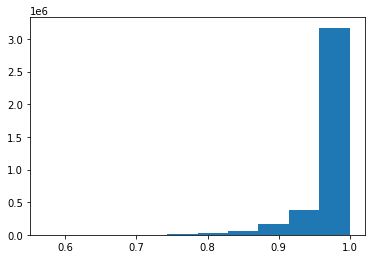

In [ ]:
plt.hist(predictions_est)
plt.show()

##Case

In [ ]:
iptest = '104.173.187.33'

top_k = get_top_n(predictions, n=10)
top_k_for_ip_curr = pd.DataFrame(top_k[iptest],columns=['rexUrl','score'])

# Recommended items
recommended_at_k = top_k_for_ip_curr[top_k_for_ip_curr.score>0.5].rexUrl.values

#Possible Relevant items
#Get true temporally held out listings for that user
true_for_ip_curr = testset[testset.ip==iptest].rexUrl.values

In [ ]:
true_for_ip_curr

array(['22718-figueroa-st-unit-21', '3591-soledad-canyon-rd',
       '6345-colbath-ave'], dtype=object)

In [ ]:
# Check, was one of these true test set listings in the top 10 recs?
'6345-colbath-ave' in recommended_at_k

False

In [ ]:
# pull off the listing names of top 10 recommendations PLUS one of the true test set listings
top10recs_case = list(recommended_at_k[:9])
top10recs_case.append(recommended_at_k[np.argwhere(np.array(recommended_at_k)=='3591-soledad-canyon-rd')[0][0]])

In [ ]:
# read in listing data to visualize the listings
listing_data = pd.read_pickle('LOG_siamese_data_11_12.pkl')

toprecs_case = pd.DataFrame({'rexUrl':top10recs_case})
toprecs_case = toprecs_case.merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
toprecs_case['sqft'] = np.exp(toprecs_case['log_sqft']).map('{:,.0f}'.format)
toprecs_case['price'] = np.exp(toprecs_case['log_price']).map('{:,.0f}'.format)
toprecs_case['total_rooms'] = np.exp(toprecs_case['log_total_rooms'])

In [ ]:
# relevant features to visualize
cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

toprecs_case[cols]

,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,1435-w-146th-st-apt-202,"1,028","370,000",2.0,4.0,2.0,1.0
1,10419-bellder-dr,"7,370","2,600,000",6.0,6.0,7.0,0.0
2,5850-ernest-ave,"1,902","1,175,000",4.0,5.0,4.0,0.0
3,11473-killion-st,"3,358","1,200,000",8.0,6.0,4.0,0.0
4,21314-nandina-ln-unit-202,943,"326,531",2.0,5.0,2.0,1.0
5,746-n-eucalyptus-ave-apt-21,"1,045","367,000",2.0,4.0,2.0,1.0
6,24718-via-kostas,"2,425","879,000",3.0,8.0,3.0,0.0
7,15622-nahin-ln,"3,619","694,950",5.0,13.0,4.0,0.0
8,11218-camarillo-st-apt-104,"1,860","619,000",3.0,6.0,3.0,1.0
9,3591-soledad-canyon-rd,"1,680","575,000",3.0,7.0,2.0,0.0


Unfortunately, even though the test set listing (at the bottom) was not completely different from some of the other listings in the top 10, it was likely not included in "top 10" since most predictions were 1 to begin with. 

---

### User Study
Making all combinations of recommendations to present in the user study

In [ ]:
from itertools import combinations 
user_testing_listings = ['840-e-green-st-unit-224', '175-sequoia-dr', '1245-cordova-st-unit-301', '18726-vista-del-canon-unit-e','2727-manning-ave','2022-delaware-ave-apt-4']
possible_combos_tuple = list(combinations(user_testing_listings, 3))
possible_combos = [list(i) for i in possible_combos_tuple]

In [ ]:
#generate psuedo userid/ip for "users" for each combination of 3 of the 6 options
new_user_ips = []
for p in possible_combos:
  new_user_ips.append(''.join([str(np.argwhere(np.array(user_testing_listings)==i)[0][0]+1) for i in list(p)]))

In [ ]:
# put together new users in the trainset format, and set the score they have with the listings to be median score
new_user_test = pd.DataFrame({'ip':new_user_ips,'rexUrl':list(possible_combos),'score':trainset.score.median()}).explode('rexUrl')
new_user_test.head()

,ip,rexUrl,score
0,123,840-e-green-st-unit-224,0.2314
0,123,175-sequoia-dr,0.2314
0,123,1245-cordova-st-unit-301,0.2314
1,124,840-e-green-st-unit-224,0.2314
1,124,175-sequoia-dr,0.2314


In [ ]:
# Add these new "users" who have seen the 3 selected listings to the main trainset
user_train_new = pd.concat([trainset,new_user_test],axis=0)

In [ ]:
# build the new trainset in surprise format
reader = Reader(rating_scale=(0, 1))

user_train_new_df = pd.DataFrame({'itemID': list(user_train_new.rexUrl),
                                    'userID': list(user_train_new.ip),
                                    'rating': list(user_train_new.score)})

user_test_data_pre = Dataset.load_from_df(user_train_new_df[['userID', 'itemID', 'rating']], reader)
user_test_data = user_test_data_pre.build_full_trainset()

In [ ]:
# Fit svd on new trainset with user study "user" combinations
algo_user_test = SVD(n_factors=100, n_epochs=20,lr_all=0.006,reg_all=0.05,random_state=297)

algo_user_test.fit(user_test_data)

In [ ]:
# Make predictions on all of the unseen listings
user_test_preds = algo_user_test.test(user_test_data.build_anti_testset(fill=0))

In [ ]:
# generate top 10 predictions for all users
top_10_usertest = get_top_n(user_test_preds, n=10)

In [ ]:
# for each of the user study "user" combinations, extract top 10 predictions
# resort again within top 10 by predicted score, and return top 1 prediction
top_1_preds = {}
for ip in new_user_ips:
  top_10_curr = top_10_usertest[ip]
  top_10_curr.sort(key=lambda tup: tup[1],reverse=True)
  top_1_preds[ip] = top_10_curr[0][0]

In [ ]:
# visualize top 1 prediction for each possible user-study combination
pd.DataFrame({'top_pred':top_1_preds.values(),'idx':top_1_preds.keys()},index=possible_combos_tuple)

,top_pred,idx
"(840-e-green-st-unit-224, 175-sequoia-dr, 1245-cordova-st-unit-301)",13200-pacific-promenade-apt-234-playa-vista,123
"(840-e-green-st-unit-224, 175-sequoia-dr, 18726-vista-del-canon-unit-e)",21925-centurion-way,124
"(840-e-green-st-unit-224, 175-sequoia-dr, 2727-manning-ave)",13200-pacific-promenade-apt-234-playa-vista,125
"(840-e-green-st-unit-224, 175-sequoia-dr, 2022-delaware-ave-apt-4)",13200-pacific-promenade-apt-234-playa-vista,126
"(840-e-green-st-unit-224, 1245-cordova-st-unit-301, 18726-vista-del-canon-unit-e)",13200-pacific-promenade-apt-234-playa-vista,134
"(840-e-green-st-unit-224, 1245-cordova-st-unit-301, 2727-manning-ave)",656-w-avenue-j8,135
"(840-e-green-st-unit-224, 1245-cordova-st-unit-301, 2022-delaware-ave-apt-4)",7549-coldwater-canyon-ave,136
"(840-e-green-st-unit-224, 18726-vista-del-canon-unit-e, 2727-manning-ave)",1895-club-dr,145
"(840-e-green-st-unit-224, 18726-vista-del-canon-unit-e, 2022-delaware-ave-apt-4)",7236-amigo-ave-unit-101,146
"(840-e-green-st-unit-224, 2727-manning-ave, 2022-delaware-ave-apt-4)",13200-pacific-promenade-apt-234-playa-vista,156
